
## План семинара

* знакомство
* организационные вопросы
* по следам лекции MLP


#  Данные

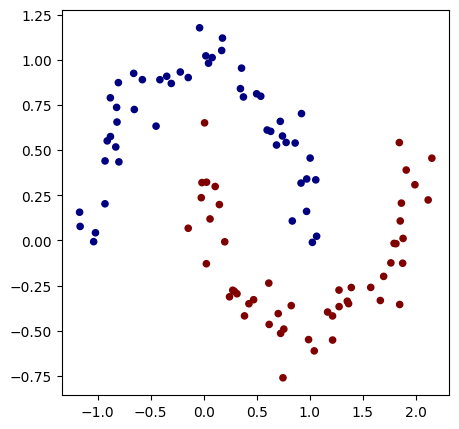

In [1]:
import numpy as np

from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=100, noise=0.1, random_state=1)

plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')


# Torch MLP

## Определяем модель

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# initialize a model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.linear_in = nn.Linear(2, 16)
        self.linear_mid = nn.Linear(16, 16)
        self.linear_out = nn.Linear(16, 1)

        # https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html
        self.activation = nn.ReLU()

        return

    def forward(self, x_coordinates):
        # x_coordinates ~ [ batch_size, 2 ]

        latents = self.activation(self.linear_in(x_coordinates)) # [ batch_size, 16 ]
        latents = self.activation(self.linear_mid(latents)) # [ batch_size, 16 ]
        scores = self.activation(self.linear_out(latents)) # [ batch_size, 1 ]
        scores = scores[:, 0] # [ batch_size ]

        return scores


model = MLP()
print(model)
print("number of parameters", sum(p.numel() for p in model.parameters()))


MLP(
  (linear_in): Linear(in_features=2, out_features=16, bias=True)
  (linear_mid): Linear(in_features=16, out_features=16, bias=True)
  (linear_out): Linear(in_features=16, out_features=1, bias=True)
  (activation): ReLU()
)
number of parameters 337


In [31]:
print("Parameters shapes:")
print([p.shape for p in model.parameters()])

Parameters shapes:
[torch.Size([16, 2]), torch.Size([16]), torch.Size([16, 16]), torch.Size([16]), torch.Size([1, 16]), torch.Size([1])]


In [32]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.6345,  0.6045],
         [-0.6783,  0.4039],
         [ 0.3402,  0.0804],
         [-0.0468, -0.4746],
         [-0.5929,  0.0512],
         [-0.3451,  0.1798],
         [-0.2280,  0.6055],
         [ 0.3025,  0.6333],
         [-0.1362,  0.6488],
         [-0.1122,  0.0179],
         [-0.3834, -0.1345],
         [-0.4637,  0.5689],
         [ 0.7056, -0.0584],
         [ 0.3539, -0.3828],
         [ 0.3708, -0.1351],
         [ 0.3476,  0.1573]], requires_grad=True),
 Parameter containing:
 tensor([-0.3980, -0.2088, -0.3937, -0.2905, -0.4455, -0.6486, -0.3159,  0.4479,
         -0.2899,  0.1500,  0.2409, -0.4147, -0.1095, -0.4384,  0.6077,  0.3901],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.1856,  0.1398, -0.0269,  0.1398,  0.2307, -0.0861,  0.0015,  0.2013,
          -0.1266,  0.1303, -0.1132,  0.0232,  0.0230,  0.2147,  0.1369,  0.0443],
         [ 0.0688,  0.1013, -0.2022,  0.0704,  0.0191, -0.0804, -0.0877,  0.0103,
      

## Вычисляем лосс

In [33]:

# loss function
def loss(model, Xbatch, ybatch):

    Xbatch = torch.tensor(Xbatch).float() # [ batch_size, 2 ]
    ybatch = torch.tensor(ybatch).float() # [ batch_size ]

    # forward the model to get scores
    model_prediction = model.forward(Xbatch) # [ batch_size, 1 ]

    # svm "max-margin" loss
    losses = F.relu(1 - ybatch * model_prediction) # [ batch_size ]
    loss = losses.mean()

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p).sum() for p in model.parameters())
    total_loss = loss + reg_loss

    # also get accuracy
    accuracy = ((ybatch > 0) == (model_prediction > 0)).float().mean()
    return total_loss, accuracy

total_loss, acc = loss(model, X, y)
print(total_loss, acc)

tensor(1.0014, grad_fn=<AddBackward0>) tensor(0.5000)


In [38]:
# optimization

def train(model, learning_rate=0.1):

    Xbatch, ybatch = make_moons(n_samples=100, noise=0.1, random_state=1)
    ybatch = y * 2 - 1 # make y be -1 or 1

    for k in range(500):

        model.zero_grad() # обнуляем градиенты с предыдущего шага

        # forward
        total_loss, acc = loss(model, Xbatch, ybatch)

        # backward
        total_loss.backward() # вычисляем новые значения градиентов

        # шаг оптимизации
        # update (sgd)
        for p in model.parameters():
            p.data = p.data - learning_rate * p.grad

        if k % 50 == 0:
            print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


model = MLP()

train(model, learning_rate=0.1)

step 0 loss 0.9936438798904419, accuracy 81.0%
step 50 loss 0.6531404852867126, accuracy 80.0%
step 100 loss 0.6299959421157837, accuracy 85.0%
step 150 loss 0.6170939803123474, accuracy 86.0%
step 200 loss 0.601204514503479, accuracy 86.0%
step 250 loss 0.583534836769104, accuracy 88.0%
step 300 loss 0.5593799948692322, accuracy 88.0%
step 350 loss 0.5367722511291504, accuracy 91.0%
step 400 loss 0.5246251821517944, accuracy 94.0%
step 450 loss 0.5192930102348328, accuracy 95.0%


(-1.7609251085622153, 1.9890748914377847)

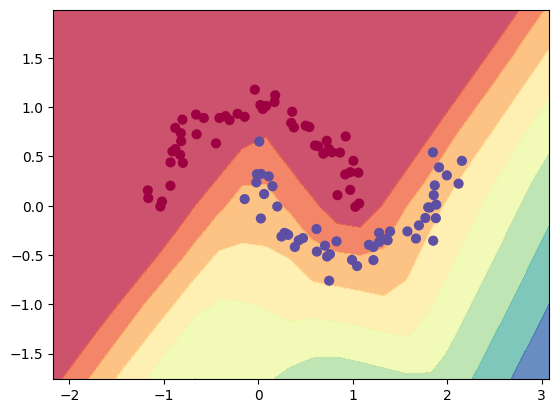

In [37]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

with torch.no_grad():
    Xbatch = torch.tensor(Xmesh).float()

    scores = model.forward(Xbatch)

Z = scores.numpy()
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Блиц

### Как луны может разделить логистическая регрессия?

### Чем наша реализация MLP отличается от LinearSVC?

### Зачем мы оборачиваем данные в `torch.tensor` внутри `def loss`?

### Как `learning_rate` влияет на скорость обучения?

### Что будет, если убрать все нелинейности из нашей модели?